In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.linear_model import LogisticRegression

## 2018-2019 Oregon Women's Basketball

A women's collegiate basketball game is divided into four 10-minute quarters; if the game is tied at the end of 4 quarters, 5-minute overtime periods are played until one team is ahead at the end of an overtime period. The file `uo_women_basketball_18-19.csv` provides the raw statistics for the team's games during the 2018-19 season. `OrQ1` - `OrQ4` is the number of points Oregon scored and `OpQ1` - `OpQ4` is the number of points their opponent scored. `OrOT1` and `OpOT1` are Oregon and the opponents score for the overtime period respectively. I will add a `OrTotal`, `OpTotal` and `Result` columns for clarity. (`Result` is 1 for Oregon win and 0 for loss)

In [9]:
bbgames = pd.read_csv('uo_women_basketball_18-19.csv')

bbgames['OrTotal'] = bbgames['OrQ1'] + bbgames['OrQ2'] + bbgames['OrQ3']  + bbgames['OrQ4'] + bbgames['OrOT1']
bbgames['OpTotal'] = bbgames['OpQ1'] + bbgames['OpQ2'] + bbgames['OpQ3']  + bbgames['OpQ4'] + bbgames['OpOT1']
bbgames['Result'] = (bbgames['OrTotal'] > bbgames['OpTotal']).replace(True, 1).replace(False, 0)
bbgames.head()

,Opponent,Location,Date,OrQ1,OrQ2,OrQ3,OrQ4,OpQ1,OpQ2,OpQ3,OpQ4,OrOT1,OpOT1,OrTotal,OpTotal,Result
0,Alaska Fairbanks,AWAY,11/06/18,34,26,29,26,9,13,8,6,0,0,115,36,1
1,Syracuse,HOME,11/10/18,20,14,14,27,10,17,17,29,0,0,75,73,1
2,Utah State,AWAY,11/14/18,30,19,20,19,15,13,15,14,0,0,88,57,1
3,Buffalo,HOME,11/18/18,26,23,31,22,16,23,21,22,0,0,102,82,1
4,UC Riverside,HOME,11/23/18,23,29,25,17,11,7,13,13,0,0,94,44,1


Oregon was most known for outscoring the opposition in the 1st quarter, and again in the 3rd quarter. The fractional scoring differential for each quarters will work well as an independent variables for a logistic regression on this data because the fraction varies from -1 to 1.

$Q1~fraction = \frac{Oregon~Q1~points~-~Opponent~Q1~points}{Oregon~Q1~points~+~Opponent~Q1~points}$

Text(0, 0.5, 'Win or Loss')

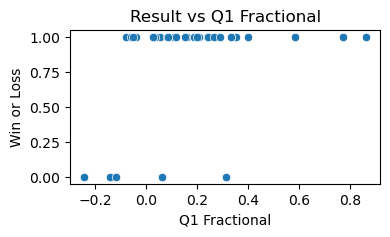

In [3]:
bbgames['Q1fraction'] = (bbgames['OrQ1'] - bbgames['OpQ1']) / (bbgames['OrQ1'] + bbgames['OpQ1'])
bbgames['Q2fraction'] = (bbgames['OrQ2'] - bbgames['OpQ2']) / (bbgames['OrQ2'] + bbgames['OpQ2'])
bbgames['Q3fraction'] = (bbgames['OrQ3'] - bbgames['OpQ3']) / (bbgames['OrQ3'] + bbgames['OpQ3'])
bbgames['Q4fraction'] = (bbgames['OrQ4'] - bbgames['OpQ4']) / (bbgames['OrQ4'] + bbgames['OpQ4'])

plt.figure(figsize=(4,2))
sns.scatterplot(data=bbgames, x='Q1fraction', y='Result')
plt.title('Result vs Q1 Fractional') 
plt.xlabel('Q1 Fractional')
plt.ylabel('Win or Loss')

In [4]:
# run logistic regression on the fractional scoring differential
model_q1f = LogisticRegression(C = 15000) # set C to 'turn off' regularization since dataset is small
model_q2f = LogisticRegression(C = 15000) # C = 1/lambda so as C gets large regularization approaches 0
model_q3f = LogisticRegression(C = 15000)
model_q4f = LogisticRegression(C = 15000)

y = np.array(bbgames['Result'])
x1 = np.array(bbgames[['Q1fraction']])
x2 = np.array(bbgames[['Q2fraction']])
x3 = np.array(bbgames[['Q3fraction']])
x4 = np.array(bbgames[['Q4fraction']])

model_q1f.fit(x1, y)
q1f_pred = model_q1f.predict(x1)

model_q2f.fit(x2, y)
q2f_pred = model_q2f.predict(x2)

model_q3f.fit(x3, y)
q3f_pred = model_q3f.predict(x3)

model_q4f.fit(x4, y)
q4f_pred = model_q4f.predict(x4)

I calculate loss using cross-entropy: $R(\theta) = -\frac{1}{n}\sum_{i = 1}^{n}(y_{i}\log(\hat{y})) + (1-y_{i})\log(1-\hat{y}))$

In [5]:
def cel(y_obs, y_hat):
    # have to add 1e-15 to avoid 1og(0)
    sum = (y_obs * np.log(y_hat + 1e-15)) + ((1 - y_obs) * np.log(1 - y_hat + 1e-15))
    return - (np.sum(sum) / len(y_obs))

print("The Cross-Entropy Loss of the Q1 Fractional Model is", cel(y, q1f_pred))
print("The Cross-Entropy Loss of the Q2 Fractional Model is", cel(y, q2f_pred))
print("The Cross-Entropy Loss of the Q3 Fractional Model is", cel(y, q3f_pred))
print("The Cross-Entropy Loss of the Q4 Fractional Model is", cel(y, q4f_pred))

The Cross-Entropy Loss of the Q1 Fractional Model is 2.726745504861369
The Cross-Entropy Loss of the Q2 Fractional Model is 4.544575841435615
The Cross-Entropy Loss of the Q3 Fractional Model is 4.544575841435615
The Cross-Entropy Loss of the Q4 Fractional Model is 2.726745504861369


Text(0.5, 0, 'Q4 Fractional')

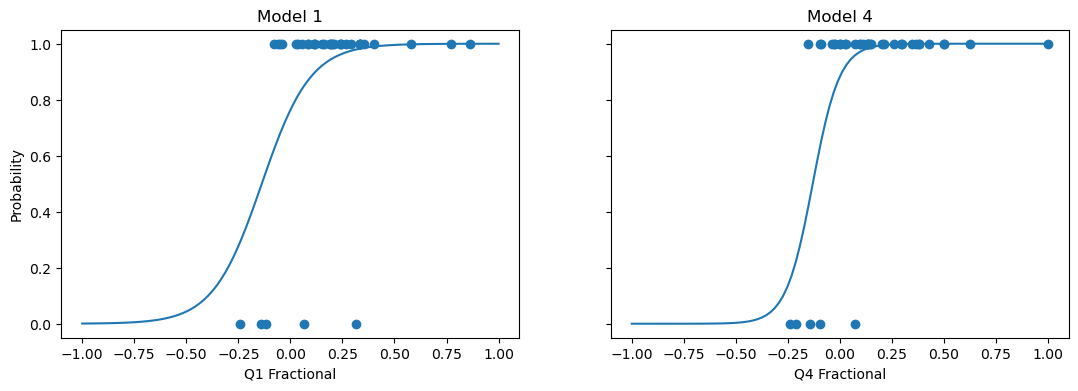

In [6]:
# model 1 and 4 are tied for lowest loss 
def sig(x):
    return 1 / (1 + np.e**(-x))

fig, axes = plt.subplots(1, 2, figsize=(13, 4), sharey=True)

axes[0].plot(np.linspace(-1, 1, 100), sig(model_q1f.coef_ * np.linspace(-1, 1, 100) + model_q1f.intercept_)[0])
axes[0].scatter(x1, y)
axes[0].set_title('Model 1')
axes[0].set_xlabel("Q1 Fractional")
axes[0].set_ylabel("Probability")

axes[1].plot(np.linspace(-1, 1, 100), sig(model_q4f.coef_ * np.linspace(-1, 1, 100) + model_q4f.intercept_)[0])
axes[1].scatter(x4, y)
axes[1].set_title('Model 4')
axes[1].set_xlabel("Q4 Fractional")

In [7]:
bbgames['Predicted Result'] = q1f_pred
positives = bbgames[bbgames['Predicted Result'] == 1]
negatives = bbgames[bbgames['Predicted Result'] == 0]
tp = len(positives[positives['Result'] == 1])
tn = len(negatives[negatives['Result'] == 0])
fp = len(positives[positives['Result'] == 0])
fn = len(negatives[negatives['Result'] == 1])

print("Accuracy:", (tp + tn) / (tp + fp + tn + fn))
print("Percision:", tp / (tp + fp))
print("Recall:", tp / (tp + fp))

Accuracy: 0.9210526315789473
Percision: 0.9166666666666666
Recall: 0.9166666666666666
